In [48]:
#imports
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np
import pickle

In [7]:
#load data from a csv file (this file is cleaned)
df = pd.read_csv('DataNExcels/df_microdt_linkedin.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,percentual_change,change_direction
0,2016-12-08 00:00:00-05:00,61.299999,61.580002,60.840000,61.009998,55.705238,21220800,1.549141,UP
1,2016-12-09 00:00:00-05:00,61.180000,61.990002,61.130001,61.970001,56.581764,27349400,0.321694,UP
2,2016-12-12 00:00:00-05:00,61.820000,62.299999,61.720001,62.169998,56.764374,20198100,1.286125,UP
3,2016-12-13 00:00:00-05:00,62.500000,63.419998,62.240002,62.980000,57.503960,35718900,-0.478620,DOWN
4,2016-12-14 00:00:00-05:00,63.000000,63.450001,62.529999,62.680000,57.230038,30352700,-0.159793,DOWN
...,...,...,...,...,...,...,...,...,...
1784,2024-01-12 00:00:00-05:00,385.489990,388.679993,384.649994,388.470001,388.470001,21645700,0.461216,UP
1785,2024-01-16 00:00:00-05:00,393.660004,394.029999,387.619995,390.269989,390.269989,27202300,-0.205404,DOWN
1786,2024-01-17 00:00:00-05:00,387.980011,390.109985,384.809998,389.470001,389.470001,22234100,1.117118,UP
1787,2024-01-18 00:00:00-05:00,391.720001,393.989990,390.119995,393.869995,393.869995,23392100,1.204008,UP


In [10]:
#separete data into target and explanatory
target = df['percentual_change']
explanatory = df[['Open', 'High', 'Low', 'Close', 'Volume']]

In [17]:
#create model
model_dt = DecisionTreeRegressor(max_depth=15)

In [18]:
model_dt.fit(X=explanatory, y=target)

DecisionTreeRegressor(max_depth=15)

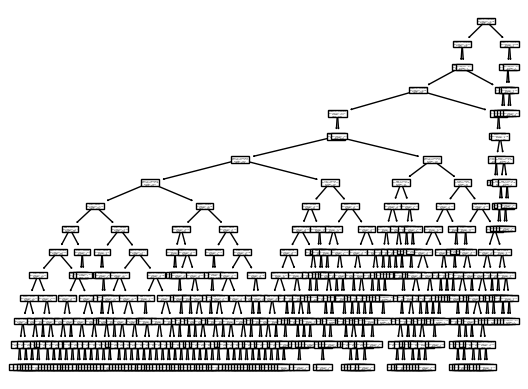

In [19]:
#plot our tree
plot_tree(decision_tree=model_dt, feature_names=model_dt.feature_names_in_);

In [22]:
#predict
y_pred = model_dt.predict(X=explanatory)
y_pred

array([ 0.11390714,  0.25417862,  0.11390714, ...,  0.60354793,
        0.47202923, -0.54475388])

In [26]:
df_predictions = df[['percentual_change']].copy()
df_predictions['prediction'] = y_pred
df_predictions

,percentual_change,prediction
0,1.549141,0.113907
1,0.321694,0.254179
2,1.286125,0.113907
3,-0.478620,0.435360
4,-0.159793,0.188104
...,...,...
1784,0.461216,0.404175
1785,-0.205404,0.098376
1786,1.117118,0.603548
1787,1.204008,0.472029


In [32]:
score = model_dt.score(X=explanatory, y=target)
print(f'Model precision is {score*100:.2f}%')

Model precision is 53.91%


In [35]:
#Calculate the error
df_predictions['error'] = df_predictions['prediction'] - df_predictions['percentual_change']
df_predictions

,percentual_change,prediction,error
0,1.549141,0.113907,-1.435234
1,0.321694,0.254179,-0.067515
2,1.286125,0.113907,-1.172218
3,-0.478620,0.435360,0.913981
4,-0.159793,0.188104,0.347897
...,...,...,...
1784,0.461216,0.404175,-0.057041
1785,-0.205404,0.098376,0.303780
1786,1.117118,0.603548,-0.513570
1787,1.204008,0.472029,-0.731979


In [39]:
#sum all errors
df_predictions['error2'] = df_predictions.error**2 #multyiply it because of negative sums
sse = df_predictions.error2.sum()

2626.692988693757

In [41]:
mse = df_predictions.error2.mean()
mse

1.4682465001083045

In [43]:
rmse = np.sqrt(mse)
rmse # this is our standart deviation

1.2117122183539721

<AxesSubplot: >

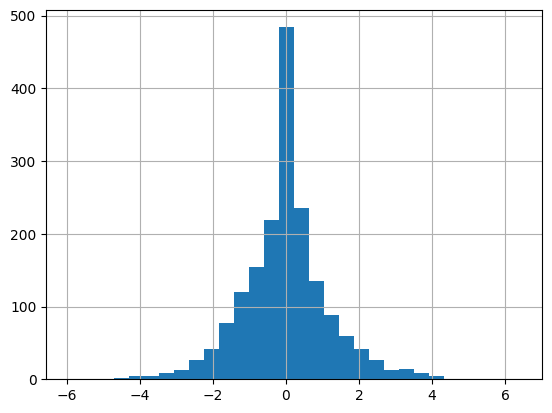

In [44]:
df_predictions.error.hist(bins=30)

In [50]:
#save model into a pickle file
with open("models/model_dt_Regression.pkl", 'wb') as f:
    pickle.dump(model_dt, f)